**Load Data**

In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
data = sio.loadmat('umist_cropped.mat')

In [3]:
people = data['facedat'][0]

In [4]:
X = []
y = []
for idx, p in enumerate(people):
    for i in p.T:
        y += [idx]
        X += [i.T]
original_shape = np.shape(X)         
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [5]:
X.shape

(575, 112, 92)

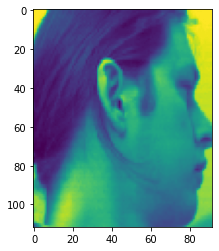

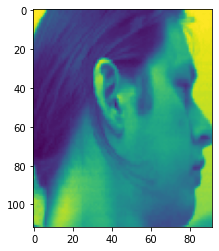

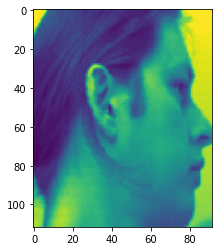

In [6]:
for x in X[:3]:
    plt.imshow(x)
    plt.show()

**Preprocesing**

In [6]:
n_classes = len(np.unique(y))

In [12]:
class Flatten():
    def fit(self, data, y):
        return self
    def transform(self, data):
        return data.reshape(len(data),-1)

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

pipe = Pipeline([
    ("flatten", Flatten()),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components = 0.99)),
    ("kmeans", KMeans(random_state=42)),
    ("nn", MLPClassifier(solver='adam', random_state=42,max_iter=1000))
])

In [36]:
params = {
    "kmeans__n_clusters" : range(80,140,5), 
    "nn__activation" : ["relu", "tanh"],
    "nn__hidden_layer_sizes": [(120,80,60,40),(80,60,40,40)]
}

gridsearch = GridSearchCV(pipe, params, return_train_score = True, cv = 5, scoring = "accuracy")

In [37]:
from sklearn.model_selection import train_test_split
# Break up the dataset into non-overlapping training (80%) and testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y)

In [38]:
gridsearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('flatten',
                                        <__main__.Flatten object at 0x00000207BC55DE20>),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.99)),
                                       ('kmeans', KMeans(random_state=42)),
                                       ('nn',
                                        MLPClassifier(max_iter=1000,
                                                      random_state=42))]),
             param_grid={'kmeans__n_clusters': range(80, 140, 5),
                         'nn__activation': ['relu', 'tanh'],
                         'nn__hidden_layer_sizes': [(120, 80, 60, 40),
                                                    (80, 60, 40, 40)]},
             return_train_score=True, scoring='accuracy')

In [62]:
gridsearch.best_params_

{'kmeans__n_clusters': 135,
 'nn__activation': 'relu',
 'nn__hidden_layer_sizes': (120, 80, 60, 40)}

In [63]:
model = gridsearch.best_estimator_

In [64]:
model

Pipeline(steps=[('flatten', <__main__.Flatten object at 0x00000207BC6A0820>),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('kmeans', KMeans(n_clusters=135, random_state=42)),
                ('nn',
                 MLPClassifier(hidden_layer_sizes=(120, 80, 60, 40),
                               max_iter=1000, random_state=42))])

In [67]:
metrics = pd.DataFrame.from_dict(gridsearch.cv_results_)

In [68]:
metrics.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       6.772598      1.274337         0.040600        0.001356   
1       5.359201      0.631847         0.042600        0.001743   
2       3.583598      0.320868         0.041602        0.002418   
3       3.122001      0.074787         0.041400        0.002330   
4       6.479599      1.126562         0.043401        0.002576   

  param_kmeans__n_clusters param_nn__activation param_nn__hidden_layer_sizes  \
0                       80                 relu            (120, 80, 60, 40)   
1                       80                 relu             (80, 60, 40, 40)   
2                       80                 tanh            (120, 80, 60, 40)   
3                       80                 tanh             (80, 60, 40, 40)   
4                       85                 relu            (120, 80, 60, 40)   

                                              params  split0_test_score  \
0  {'kmeans__n_clusters': 80, 'nn__activation': '...           0.869565   
1  {'kmeans__n_clusters': 80, 'nn__activation': '...           0.956522   
2  {'kmeans__n_clusters': 80, 'nn__activation': '...           0.869565   
3  {'kmeans__n_clusters': 80, 'nn__activation': '...           0.619565   
4  {'kmeans__n_clusters': 85, 'nn__activation': '...           0.967391   

   split1_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0           0.923913  ...         0.906522        0.030435               19   
1           0.934783  ...         0.947826        0.021077                7   
2           0.706522  ...         0.769565        0.066438               27   
3           0.619565  ...         0.660870        0.048318               34   
4           0.923913  ...         0.945652        0.022800               10   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.864130            1.000000            1.000000   
1            0.997283            1.000000            1.000000   
2            0.961957            0.866848            0.807065   
3            0.619565            0.777174            0.801630   
4            1.000000            0.997283            1.000000   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0            1.000000            0.918478          0.956522         0.055955  
1            1.000000            0.997283          0.998913         0.001331  
2            0.942935            0.788043          0.873370         0.069866  
3            0.793478            0.663043          0.730978         0.074913  
4            0.997283            1.000000          0.998913         0.001331  

[5 rows x 23 columns]

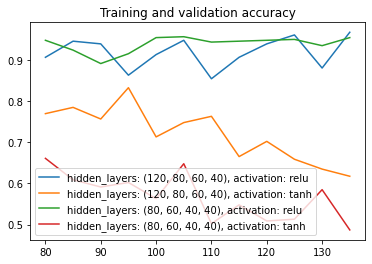

In [75]:
for layer in params['nn__hidden_layer_sizes']:
    for activation in params['nn__activation']:
        df = metrics.loc[(metrics['param_nn__activation'] == activation) & (metrics['param_nn__hidden_layer_sizes'] == layer)]
        plt.plot(df['param_kmeans__n_clusters'], df["mean_test_score"], label=f"hidden_layers: {layer}, activation: {activation}")

plt.title('Training and validation accuracy')
plt.legend()        
plt.show()        

In [66]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,model.predict(X_test))

0.8869565217391304